# hysteresis_demo.ipynb
The purpose of this notebook is to demonstrate the construction of magnetic hysteresis models & their use in computing hysteresis quantities.

In [1]:
#%pip install git+https://github.com/radiasoft/rsradia.git

from numpy import array, zeros
from matplotlib import pyplot as plt
from rsradia.hysteresis import MU0, JilesAtherton, Preisach

ModuleNotFoundError: No module named 'rsradia.hysteresis'

## Constructing & using hysteresis models

### Jiles-Atherton Models
The cell below constructs a Jiles-Atherton model for grade 20 steel. This is done by defining a magnetizing field step size ```dH```, an ```integrator``` for solving magnetization equations, and the physical parameters of the model, done here using a dictionary (```ja_params```). The physical parameters of the model are:

* ```alpha```: Domain coupling strength
* ```a```: Domain wall density
* ```Ms```: Saturation magnetization of material
* ```k```: Pinning site breaking energy
* ```c```: Magnetization reversability
* ```wa (0)```: Relative weight of anisotropic contributions to magnetization
* ```Ka (0)```: Average anisotropy energy density
* ```psi (0)```: Angle between anisotropy easy axis & magnetizing field

and the integrator must be one of:

* ```EULER```: Basic Euler integrator
* ```RK4```: Standard 4th order Runge-Kutta integrator
* ```RK45```: Dormand-Prince 4th/5th order Runge-Kutta integrator

Parameters can be set to obtain models for both isotropic and anisotropic materials. If the parameters for either the relative anisotropy contribution (`'wa'`) or the average anisotropy energy density (`'Ka'`) are not set or are set to 0 (true by default), an isotropic model will be used.

In [2]:
# Set Jiles-Atherton model parameters for low-carbon steel
ja_params = {
    'dH' : 10,
    'integrator' : 'RK45',
    
    'alpha': 4.93e-4,
    'a': 399,
    'Ms': 1.35e6,
    'k': 300,
    'c': 0.120,
    'wa': 0,
    'Ka': 0,
    'psi': 0,
}

# Construct the Jiles-Atherton hysteresis model
ja_model = JilesAtherton(**ja_params)

# Note: Once parameters have been passed, a model can be stored using the 'save'
# method. A stored model can be initialized in-context using the 'load' method.

#ja_model.save("path_to_model_storage")
# stored_model = JilesAtherton.load("path_to_stored_model")

Once a hysteresis model has been constructed (or loaded), it already contains a definition for the major hyseresis loop stored in the class members ```H_major``` and ```B_major```. This information can then be used to compute additional hysteresis quantities as the need arises.

As an example, the next cell will compute hysteresis quantities for each of the following use cases:
* Computing a minor hysteresis loop reaching 1/5 of the saturation field
* Computing a portion of the major hysteresis loop, beginning at a turnaround point
* Computing an interpolated magnetic flux density at an arbitrary, prescribed point
* Computing a portion of the major hysteresis loop beginning at a prescribed point

In [3]:
# Define the maximum applied field & magnetic flux density for ease of use
H_max = ja_model.H_major.max()
B_max = ja_model.B_major.max()

# Use the Jiles-Atherton model to compute hysteresis along a minor loop
minor_path = array([[0, H_max/5], [H_max/5, -H_max/5], [-H_max/5, H_max/5]])
H_minor, B_minor = ja_model.path(minor_path, 1e-6)

# Use the Jiles-Atherton model to compute hysteresis along a portion of the major loop
partial_path = array([[H_max, 0]])
H_partial, B_partial = ja_model.path(partial_path, B_max/MU0)

# Use the Jiles-Atherton model to compute magnetic flux density for an arbitrary applied field
H_point = -1005.05050508
B_point_upper = ja_model.point(H_point, 'upper')

# Use a magnetic flux density at a prescribed applied field to compute hysteresis along a path
point_path = array([[H_point, 0]])
B_point_lower = ja_model.point(H_point, 'lower')
H_point_path, B_point_path = ja_model.path(point_path, B_point_lower/MU0)

This cell will plot the hysteresis quantities computed above, along with the major hysteresis curve computed when the model was initialized.

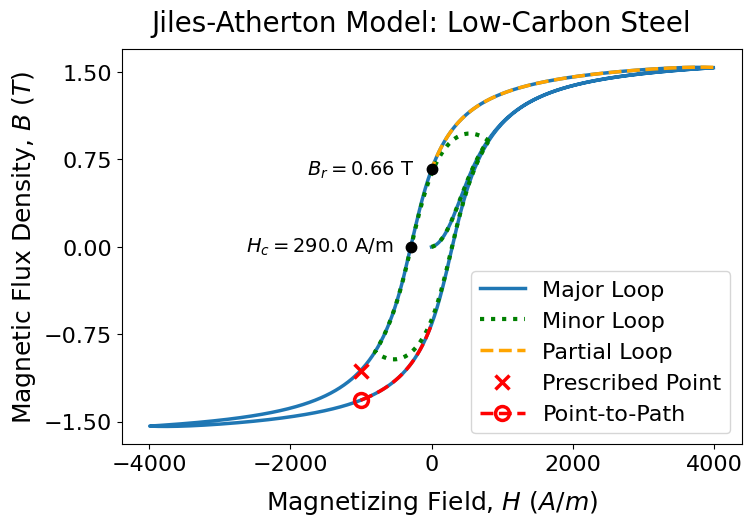

In [4]:
# Define tick values for plotting
H_ticks = [-4000, -2000, 0, 2000, 4000]
B_ticks = [-1.5, -.75, 0, .75, 1.5]
Hc = ja_model.coercivity[0]
Br = ja_model.remanence[0]

# Plot the example hysteresis quantities for the Jiles-Atherton model
fig, ax = plt.subplots(figsize=(8,5))
fig.suptitle(r"Jiles-Atherton Model: Low-Carbon Steel",fontsize=20,y=.98)
ax.plot(ja_model.H_major, ja_model.B_major,lw=2.5,label=r"Major Loop")
ax.plot(H_minor, B_minor, ':', color='g', lw=3, label=r"Minor Loop")
ax.plot(H_partial, B_partial, '--', color='orange', lw=2.5, label=r"Partial Loop")
ax.plot(H_point, B_point_upper, 'x', color='red', ms=10, mew=2.5, label=r"Prescribed Point")
ax.plot(H_point_path, B_point_path, 'r--', lw=2.5, marker='o', mfc='none', ms=10, mew=2.5, markevery=[0], label=r"Point-to-Path")
ax.plot(Hc, 0, 'ko', ms=7.5)
ax.text(Hc-250, 0, r"$H_c = ${:.1f} A/m".format(abs(Hc)), ha='right', va='center', fontsize=14)
ax.plot(0, Br, 'ko', ms=7.5)
ax.text(-250, Br, r"$B_r = ${:.2f} T".format(Br), ha='right', va='center', fontsize=14)
ax.legend(fontsize=16, loc='lower right')
ax.axis(1.1*array([ja_model.H_major.min(), ja_model.H_major.max(), ja_model.B_major.min(), ja_model.B_major.max()]))
ax.set_xlabel(r"Magnetizing Field, $H\ (A / m)$", fontsize=18, labelpad=10)
ax.set_ylabel(r"Magnetic Flux Density, $B\ (T)$",fontsize=18)
ax.set_xticks(H_ticks)
ax.set_yticks(B_ticks)
ax.tick_params(labelsize=16)
fig.subplots_adjust(top=.9)
fig.show()

#### How It Works

This implementation of the Jiles-Atherton model functions by numerically integrating the differential equation from Jiles & Atherton (1984):

$\frac{dM}{dH} = \frac{1}{1+c}\frac{M_\text{an}-M}{\delta k - \alpha (M_\text{an} - M)} + \frac{c}{1+c}\ \frac{dM_\text{an}}{dH}$

where $M$ is the overall magnetization, $M_\text{an}$ is the anhysteretic contribution, $H$ is the applied magnetic field, $\delta$ is the sign of changes in the applied field, and all other symbols are the parameters of the Jiles-Atherton model listed above. This implementaiton also includes the corrected anisotropic extension to the model developed in Ramesh et al (1996) and Szewczyk (2014) so that:

$M_\text{an} = (1-w_\text{an})\ M_\text{an}^\text{iso} + w_\text{an}\ M_\text{an}^\text{aniso}$

where $w_\mathrm{an}$ is the relative weight of anisotropic effects and $M_\text{an}^\text{iso}$ and $M_\text{an}^\text{aniso}$ are the isotropic and anisotropic anhysteretic magnetization.

### Preisach Models
The cell below defines a Preisach model for grade 20 steel. This is done by providing a magnetizing field step size ```dH``` and the physical parameters of the model, done here using a dictionary (```pr_params```). The physical parameters of the model are:

* ```Ms```: Saturation magnetization
* ```alpha```: Domain coupling strength
* ```ab_max```: Maximum hysteron field value
* ```ab_res```: Grid spacing of hysteron field values
* ```distribution (Gaussian)```: Distribution to use for the Preisach density
* ```dist_params (None)```: Parameters for the Preisach density distribution

The chosen distribution can either be one of:

* ```UNIFORM```: Uniform distribution
    * *No parameters needed*
* ```GAUSSIAN```: Gaussian distribution
    * *2x1 mean vector (e.g. array([0,0])*
    * *2x2 covariance matrix (e.g. array([[0.1,0],[0,0.1]])*
* ```GMIXTURE```: Gaussian mixture with N mixands (N>=1)
    * *Nx2 array of mean vectors (e.g. array([[0,0], [0.5,0.5]])*
    * *Nx2x2 array of covariance matrices (e.g. array([[[0.1,0],[0,0.1]], [[0.2,0],[0,0.2]])*
    * *Nx1 array of mixand weights, should sum to 1 (e.g. array([0.6, 0.4]))*

(with necessary parameters ```dist_params``` given as a list or tuple), or a 2D array of weights for the hysteron grid.

In [5]:
# Define parameters for the Preisach density
pr_mus = array([[.05,-.05], [0,.3], [-.3,0], [-.5,-.6], [.6,.5]])
pr_Sigmas = array([[[.03,.01],[.01,.03]], [[.003,0],[0,.04]], [[.04,0],[0,.003]], \
                   [[.05,.04],[.04,.05]], [[.04,.03],[.03,.04]]])
pr_ws = array([.75, .025, .025, .1, .1])

# Set model parameters for grade 20 steel
pr_params = {
    'dH': 10,
    
    'Ms': 1.2e6,
    'ab_max': 4e3,
    'ab_res': 25,
    'distribution': 'gmixture',
    'dist_params': (pr_mus, pr_Sigmas, pr_ws)
}

#    'distribution': 'gaussian',
#    'dist_params': (array([.15,-.15]), array([[.05, .01],[.01, .05]]))
#}

# Construct a Preisach model & compute its hysteresis
pr_model = Preisach(**pr_params)

# Note: Once parameters have been passed, a model can be stored using the 'save'
# method. A stored model can be initialized in-context using the 'load' method.

# pr_model.save("path_to_model_storage")
# stored_model = Preisach.load("path_to_stored_model")

In [6]:
# Define the maximum applied field & magnetic flux density for ease of use
H_max = pr_model.H_major.max()
B_max = pr_model.B_major.max()

# Use the Preisach model to compute hysteresis along a minor loop
minor_path = array([[0, H_max/5], [H_max/5, -H_max/5], [-H_max/5, H_max/5]])
H_minor, B_minor = pr_model.path(minor_path, 0)

# Use the Preisach model to compute hysteresis along a portion of the major loop
partial_path = array([[H_max, 0]])
H_partial, B_partial = pr_model.path(partial_path, B_max/MU0)

# Use the Preisach model to compute magnetic flux density for an arbitrary applied field
H_point = -1005.05050508
B_point_upper = pr_model.point(H_point, 'upper')

# Use a magnetic flux density at a prescribed applied field to compute hysteresis along a path
point_path = array([[H_point, 0]])
B_point_lower = pr_model.point(H_point, 'lower')
H_point_path, B_point_path = pr_model.path(point_path, B_point_lower/MU0)

This cell will plot the density used in the Preisach model constructed above, as well as the major hysteresis loop it produced.

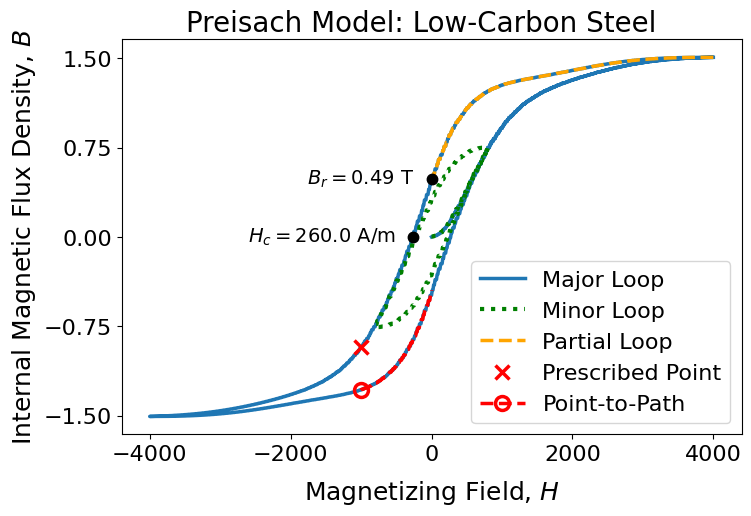

In [7]:
Hc = pr_model.coercivity[0]
Br = pr_model.remanence[0]

# Plot the example hysteresis quantities for the Preisach model
fig, ax = plt.subplots(figsize=(8,5))
fig.suptitle(r"Preisach Model: Low-Carbon Steel",fontsize=20,y=.96)
ax.plot(pr_model.H_major, pr_model.B_major, lw=2.5, label=r"Major Loop")
ax.plot(H_minor, B_minor, ':', color='g', lw=3, label=r"Minor Loop")
ax.plot(H_partial, B_partial, '--', color='orange', lw=2.5, label=r"Partial Loop")
ax.plot(H_point, B_point_upper, 'x', color='red', ms=10, mew=2.5, label=r"Prescribed Point")
ax.plot(H_point_path, B_point_path, 'r--', lw=2.5, marker='o', mfc='none', ms=10, mew=2.5, markevery=[0], label=r"Point-to-Path")
ax.plot(Hc, 0, 'ko', ms=7.5)
ax.text(Hc-250, 0, r"$H_c = ${:.1f} A/m".format(abs(Hc)), ha='right', va='center', fontsize=14)
ax.plot(0, Br, 'ko', ms=7.5)
ax.text(-250, Br, r"$B_r = ${:.2f} T".format(Br), ha='right', va='center', fontsize=14)
ax.legend(fontsize=16, loc='lower right')
ax.axis(1.1*array([pr_model.H_major.min(), pr_model.H_major.max(), pr_model.B_major.min(), pr_model.B_major.max()]))
ax.set_xlabel(r"Magnetizing Field, $H$", fontsize=18, labelpad=10)
ax.set_ylabel(r"Internal Magnetic Flux Density, $B$",fontsize=18)
ax.set_xticks(H_ticks)
ax.set_yticks(B_ticks)
ax.tick_params(labelsize=16)
fig.subplots_adjust(top=.9)
fig.show()

#### How It Works
Unlike the Jiles-Atherton model, the Preisach model does not involve the integration of differential equations for hysteresis quantities. Instead, it uses a grid method in which a weighted average, parameterized by a density over a 2D grid, is taken over a series of simple relays called hysterons. Each hysteron features a "turn-on" and "turn-off" value of applied magnetic fields, and remains in the most recent (on/off) state for fields between the two.

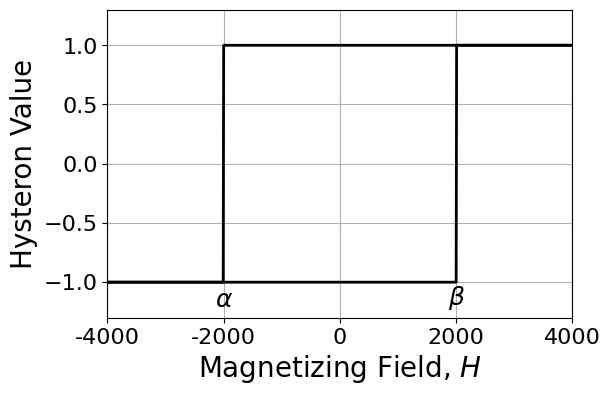

In [8]:
Bs = -4000 + array(range(1000))*8
alpha = -2000
beta = 2000
rho_up = 1 - 2 *(Bs<alpha)
rho_down = -1 + 2*(Bs>beta)

H_ticks = [-4000, -2000, 0, 2000, 4000]
B_ticks = [-1, -.5, 0, .5, 1.]

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(Bs, rho_up, 'k-', lw=2)
ax.plot(Bs, rho_down, 'k-', lw=2)
ax.text(alpha, -1.25, r"$\alpha$", fontsize=18, ha='center', va='bottom')
ax.text(beta, -1.25, r"$\beta$", fontsize=18, ha='center', va='bottom')
ax.set_xlabel(r"Magnetizing Field, $H$",fontsize=20)
ax.set_ylabel(r"Hysteron Value",fontsize=20)
ax.set_xticks(H_ticks)
ax.set_xticklabels(["-4000", r"-2000", "0", r"2000", "4000"])
ax.set_yticks(B_ticks)
ax.axis([-4000, 4000, -1.3, 1.3])
ax.tick_params(labelsize=16)
plt.grid()
fig.show()

By defining a series of these hysterons with switching values covering the +/- saturation range of a material, a weighted sum can be carried out which determines the overall magnetization of the material according to:

$M(H)=\sum\limits_{\beta}\sum\limits_{\alpha<\beta}\mu_{\alpha,\beta}R_{\alpha,\beta}(H)$

where $\mu_{\alpha, \beta}$ are elements of the hysteron weight distribution, and $R_{\alpha, \beta}(H)$ are the values of individual hysterons. Since the switch-on field value must be higher than the switch-off value, only hysterons for which $\alpha<\beta$ are physical and need to be considered. The Preisach model is therefore parameterized entirely by the chosen grid of possible hysteron switching values and the weights assigned to each point on the grid.

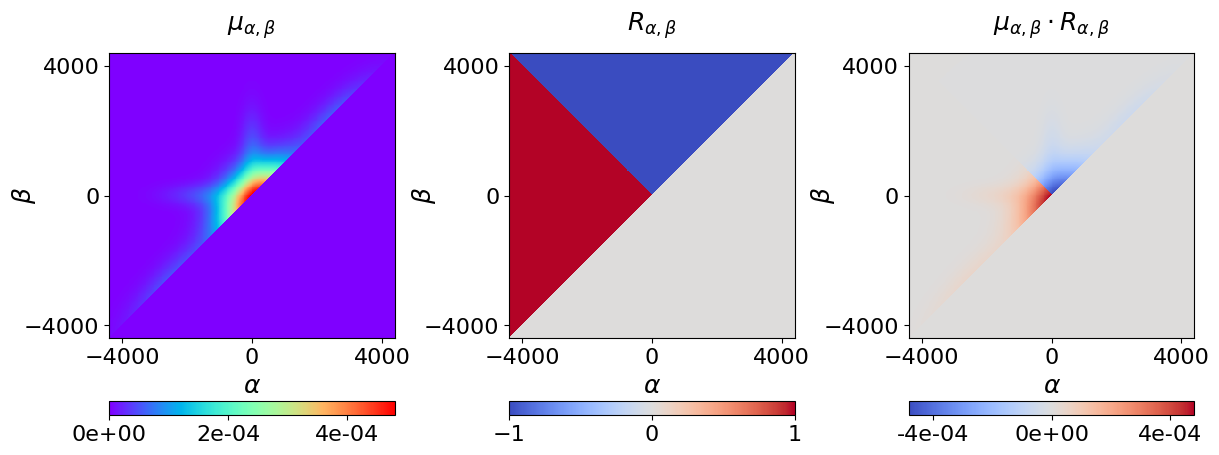

In [9]:
# Choose example values for magnetizing field and initial magnetization
H_ex = 0
B_ex = pr_model.point(H_ex, 'initial')

# Create the example hysteron grid
ab0 = (B_ex/pr_model.B_major.max())*pr_model._ab_max
R = zeros(len(pr_model._grid))
R[-pr_model._grid[:,0] >= pr_model._grid[:,1]-ab0] = 1
R[-pr_model._grid[:,0] < pr_model._grid[:,1]-ab0] = -1

# Compute hysteron values at a prescribed field strength
R[H_ex>pr_model._grid[:, 1]] = 1
R[pr_model._grid[:,0]>=pr_model._grid[:,1]] = 0

# Create a figure to plot results for two of Jon's datasets
n_grid = int(len(pr_model._grid)**.5)
imKwargs = {
    'origin': 'lower',
    'interpolation': 'none',
    'extent': 2*[1.1*pr_model._grid.min(), 1.1*pr_model._grid.max()],
}

fig, axs = plt.subplots(1, 3, figsize=(14,11))
axs[0].set_title(r"$\mu_{\alpha, \beta}$", fontweight='bold', fontsize='18', y=1.05)
axs[1].set_title(r"$R_{\alpha, \beta}$", fontweight='bold', fontsize='18', y=1.05)
axs[2].set_title(r"$\mu_{\alpha, \beta}\cdot R_{\alpha, \beta}$", fontweight='bold', fontsize='18', y=1.05)
dist = axs[0].imshow(pr_model._density.reshape(n_grid, n_grid).T, cmap='rainbow', **imKwargs)
cbar1 = fig.colorbar(dist, ax=axs[0], location="bottom", orientation="horizontal", format='%.0e')
cbar1.ax.tick_params(labelsize=16)
cbar1.ax.xaxis.offsetText.set_fontsize(16)
pgrid = axs[1].imshow(R.reshape(n_grid, n_grid).T, cmap='coolwarm', **imKwargs)
cbar2 = fig.colorbar(pgrid, ax=axs[1], location="bottom", orientation="horizontal")
cbar2.ax.tick_params(labelsize=16)
cbar2.ax.xaxis.offsetText.set_fontsize(16)
cbar2.ax.set_xticks([-1, 0, 1])
wgrid = axs[2].imshow((R*pr_model._density).reshape(n_grid, n_grid).T, vmin=-pr_model._density.max(), vmax=pr_model._density.max(), cmap='coolwarm', **imKwargs)
cbar3 = fig.colorbar(wgrid, ax=axs[2], location="bottom", orientation="horizontal", format='%.0e')
cbar3.ax.tick_params(labelsize=16)
cbar3.ax.xaxis.offsetText.set_fontsize(16)
cbar3.ax.set_xticks([-4e-4, 0, 4e-4])
for ax in axs:
    ax.set_xlabel(r"$\alpha$",fontsize=18)
    ax.set_ylabel(r"$\beta$",fontsize=18, labelpad=-10)
    ax.tick_params(labelsize=16)
    ax.set_xticks(H_ticks[::2])
    ax.set_yticks(H_ticks[::2])
fig.subplots_adjust(wspace=.4, bottom=.5)
fig.show()

#### Describing uncommon dynamics
Although the Jiles-Atherton model is sufficient for almost any (relatively homogeneous) bulk magnetic material and is faster to execute than the Preisach model, there are some cases in which the latter may be preferable. Especially in macrosopic, heterogeneous materials like portions of the Earth's crust complex factors like geothermal conditions and physical structuring can lead to "abnormal" hysteretic behaviors like bimodality. The cell below demonstrates how the extreme robustness of the Preisach model may be useful in reproducing such strange hysteretic features.

In [84]:
# Define parameters for the Preisach density
bimodal_mus = array([[-.8,-.1], [.1,.8]])
bimodal_Sigmas = array([[[.01,.0],[.0,.05]], [[.01,0],[0,.01]]])
bimodal_ws = array([.5, .5])

# Set model parameters for grade 20 steel
bimodal_params = {
    'dH': 10,
    
    'Ms': 1.2e6,
    'ab_max': 4e3,
    'ab_res': 50,
    'distribution': 'gmixture',
    'dist_params': (bimodal_mus, bimodal_Sigmas, bimodal_ws)
}

#    'distribution': 'gaussian',
#    'dist_params': (array([.15,-.15]), array([[.05, .01],[.01, .05]]))
#}

# Construct a Preisach model & compute its hysteresis
pr_bimodal = Preisach(**bimodal_params)

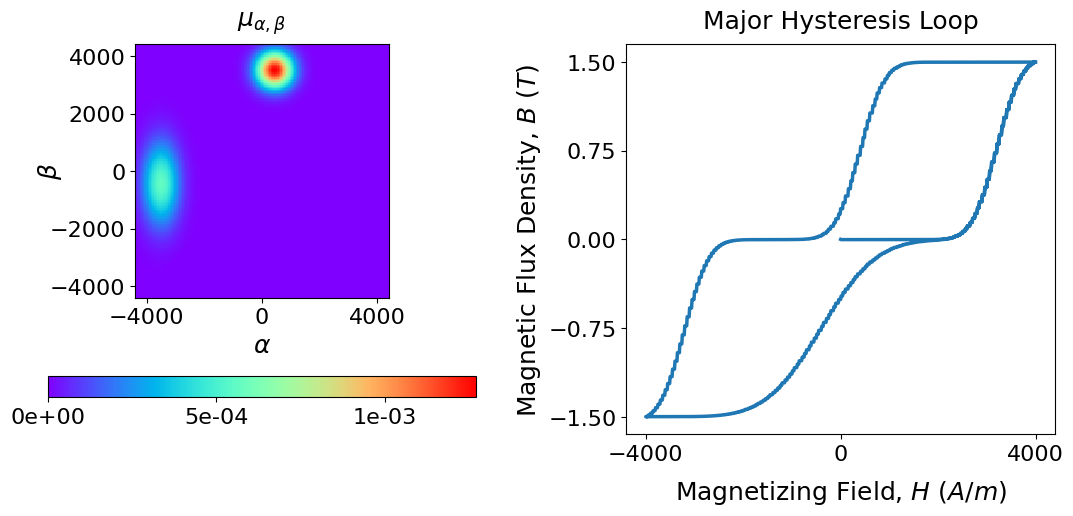

In [85]:
n_grid = int(len(pr_bimodal._grid)**.5)
fig, axs = plt.subplots(1, 2, figsize=(13,5))
axs[0].set_title(r"$\mu_{\alpha, \beta}$", fontsize='18', y=1.04)
axs[1].set_title(r"Major Hysteresis Loop", fontsize='18', y=1.02)
dist = axs[0].imshow(pr_bimodal._density.reshape(n_grid, n_grid).T, cmap='rainbow', **imKwargs)
cbar1 = fig.colorbar(dist, ax=axs[0], location='bottom', orientation="horizontal", format='%.0e', pad=.2)
cbar1.ax.tick_params(labelsize=16)
cbar1.ax.set_xticks([0, 5e-4, 1e-3])
cbar1.ax.xaxis.offsetText.set_fontsize(16)
axs[1].plot(pr_bimodal.H_major, pr_bimodal.B_major,lw=2.5,label=r"Major Loop")
axs[0].set_xlabel(r"$\alpha$",fontsize=18)
axs[0].set_ylabel(r"$\beta$",fontsize=18, labelpad=-10)
axs[1].set_xlabel(r"Magnetizing Field, $H\ (A / m)$", fontsize=18, labelpad=10)
axs[1].set_ylabel(r"Magnetic Flux Density, $B\ (T)$",fontsize=18)
axs[1].axis(1.1*array([pr_bimodal.H_major.min(), pr_bimodal.H_major.max(), pr_bimodal.B_major.min(), pr_bimodal.B_major.max()]))
for ax in axs: 
    ax.tick_params(labelsize=16)
    ax.set_xticks(H_ticks[::2])
axs[0].set_yticks(H_ticks)
axs[1].set_yticks([-1.5, -.75, 0, .75, 1.5])
fig.subplots_adjust(wspace=.35, bottom=.1)
fig.show()